# Perplexity ratio score: Kullback–Leibler divergence

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import pickle
import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from IPython.display import Image

import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import configuration as config

/mnt/arkk/llm_detector/classifier


Plan here is to take our sampling distributions of perplexity ratio scores for human and synthetic text and use them to generate a function that takes a perplexity ratio score and converts it into a Kullback-Leibler score. See the figure below from the [Wikipedia article on KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

In [2]:
Image(url = 'https://raw.githubusercontent.com/gperdrizet/llm_detector/benchmarking/benchmarking/notebooks/images/KL-Gauss-Example.png')

Plan is as follows:
2. Plot and fit the distributions of perplexity ratio scores from human and synthetic text from the training data.
3. Calculate the Kullback-Leibler divergence between the fitted distributions.
4. Use a kernel density estimate of the Kullback-Leibler divergence to get it's probability density function.
5. Use the Kullback-Leibler divergence PDF to calculate a 'Kullback-Leibler score' from the perplexity ratio score for each text fragment in the training and testing datasets.

## TODO
1. ~~Since KL divergence is not symmetrical, maybe we should include two features one for KL divergence between the human and synthetic score distributions in each direction...~~
2. ~~Maybe try some of the other fits, e.g. gaussian rather than exponential gaussian.~~ Took a good second look at the old version of the experimentation notebook and the fit residuals are without a doubt best with exponential gaussian.
3. What if we use a kernel density estimate instead of a gaussian fit on the perplexity ratio density data? This might give us a better 'fit'.

## Load and prepare data

In [3]:
with open(config.FEATURE_ENGINEERING_CLASS_INSTANCE, 'rb') as file:
    data = pickle.load(file)

First we need the distributions of perplexity ratio score values for human and synthetic text.

In [4]:
# Calculate bins for perplexity ratio score from the training data
scores = data.training.all.combined['Perplexity ratio score']
counts, bins = np.histogram(scores, bins = 100, density = True)

# Get bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate histograms for the human and combined synthetic data
human_scores = data.training.all.human['Perplexity ratio score']
synthetic_scores = data.training.all.synthetic_combined['Perplexity ratio score']

human_density, human_bins = np.histogram(human_scores, bins = bins, density = True)
synthetic_density, synthetic_bins = np.histogram(synthetic_scores, bins = bins, density = True)

Now, fit the individual distributions with an exponential gaussian:

In [5]:
# Fit an exponential gaussian to the human and synthetic scores and get fitted values for
# the bin centers calculated from the combined data
print('\nHuman fit:')
human_exp_gaussian = helper_funcs.exp_gaussian_fit(human_scores)
human_exp_gaussian_values = human_exp_gaussian.pdf(bin_centers)
print(f'  Fitted values: {human_exp_gaussian_values[:3]}...')

print('\nSynthetic fit:')
synthetic_exp_gaussian = helper_funcs.exp_gaussian_fit(synthetic_scores)
synthetic_exp_gaussian_values = synthetic_exp_gaussian.pdf(bin_centers)
print(f'  Fitted values: {synthetic_exp_gaussian_values[:3]}...')


Human fit:
  Rate: 0.6560851622088061
  Mean: 0.9512171257678067
  Variance: 0.05730946540988896
  Fitted values: [7.85714373e-36 1.19455940e-34 1.73444808e-33]...

Synthetic fit:
  Rate: 0.8174663890967695
  Mean: 0.8345664262068503
  Variance: 0.051585142643520175
  Fitted values: [2.66270531e-31 4.45977281e-30 7.05753591e-29]...


And for comparison, also use a guassian kernel density estimate to get the fit:

In [6]:
# Run the KDE and then get fitted values for the bin centers
human_kde = gaussian_kde(human_scores)
human_kde_values = human_kde.pdf(bin_centers)
print(f'Human KDE values: {human_kde_values[:3]}...')

synthetic_kde = gaussian_kde(synthetic_scores)
synthetic_kde_values = synthetic_kde.pdf(bin_centers)
print(f'Synthetic KDE values: {synthetic_kde_values[:3]}...')

Human KDE values: [2.90791874e-71 8.10836913e-63 6.23877619e-55]...
Synthetic KDE values: [0.00299713 0.00113515 0.00222544]...


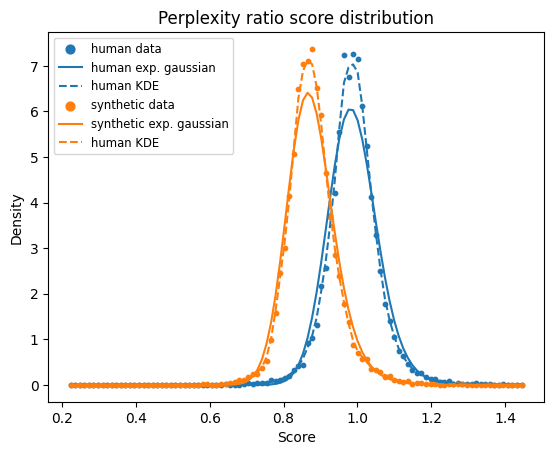

In [7]:
plot_funcs.plot_score_distribution_fits(
        'Perplexity ratio score distribution',
        bin_centers,
        human_density,
        human_exp_gaussian_values,
        human_kde_values,
        synthetic_density,
        synthetic_exp_gaussian_values,
        synthetic_kde_values
).show()

Ok, looks good to me - let's take a closer look at the fits.

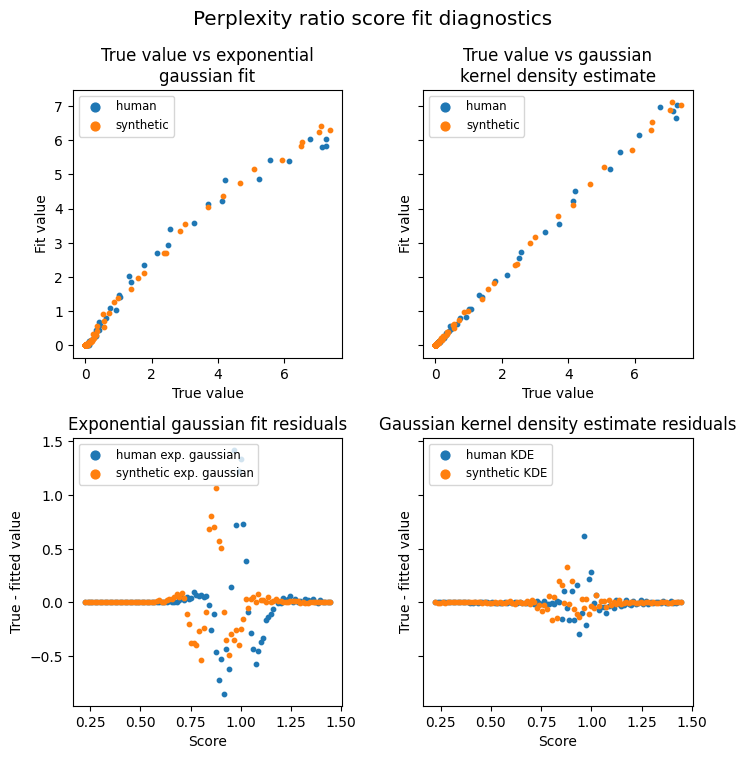

In [8]:
plot_funcs.plot_fit_diagnostics(
        'Perplexity ratio score fit diagnostics',
        bin_centers,
        human_density,
        synthetic_density,
        human_exp_gaussian_values,
        synthetic_exp_gaussian_values,
        human_kde_values,
        synthetic_kde_values
).show()

OK, looks good enough to me - now let's take a look at the Kullback-Leibler divergence of the two fits.

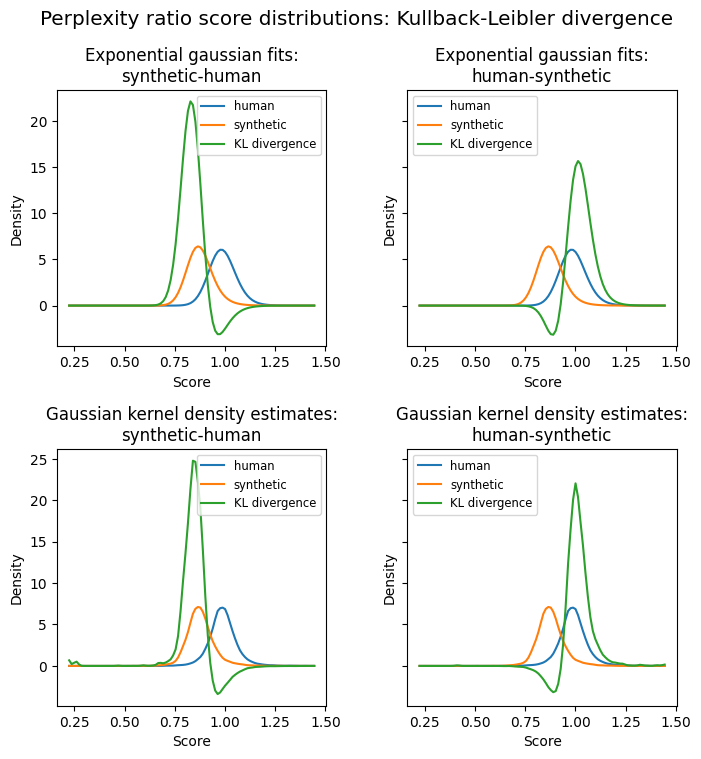

In [9]:
plot_funcs.plot_kl_divergences(
        'Perplexity ratio score distributions: Kullback-Leibler divergence',
        bin_centers,
        human_exp_gaussian_values,
        synthetic_exp_gaussian_values,
        human_kde_values,
        synthetic_kde_values

).show()

Now we need to use fitted perplexity ratio score distributions to calculate and add the KL score for each text fragment in the dataset. E.g. on the plot above a fragment with a perplexity ratio score of ~0.8 would get a synthetic-human KL divergence score of about 25, etc. To do that we need kernel density estimates for the KL divergence distributions.

Will calculate 1433 fitted values
<class 'numpy.ndarray'>
Min synthetic-human KLD count value 0
Max synthetic-human KLD count value: 2526
Min human-synthetic KLD count value 0
Max human-synthetic KLD count value: 1882


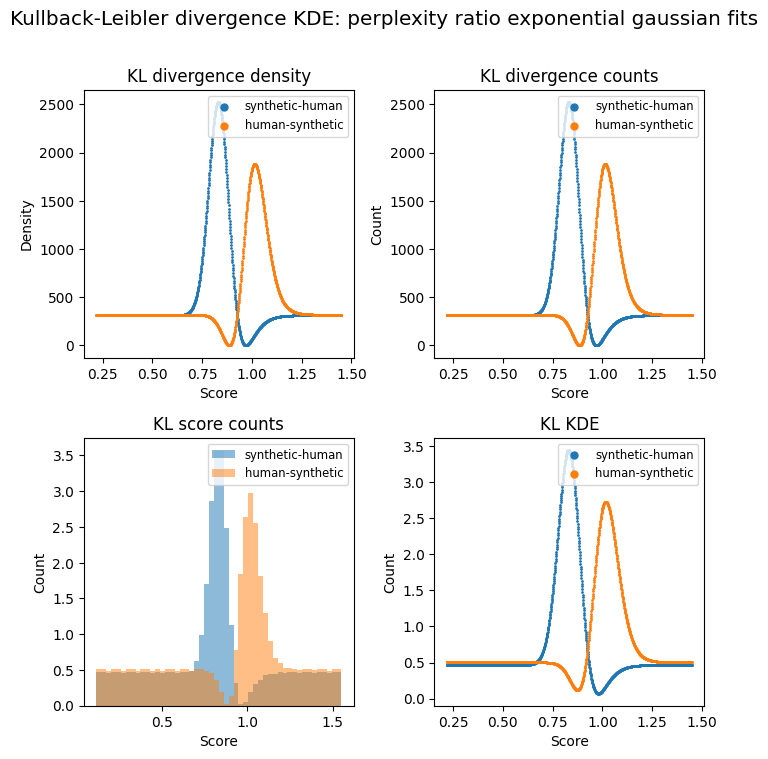

In [10]:
exp_gaussian_synthetic_human_kld_kde, exp_gaussian_human_synthetic_kld_kde, plt = helper_funcs.get_kl_kde(
    'Kullback-Leibler divergence KDE: perplexity ratio exponential gaussian fits', 
    scores, 
    human_exp_gaussian, 
    synthetic_exp_gaussian,
    0.1,
    0.001
)

plt.show()

Will calculate 1433 fitted values
<class 'numpy.ndarray'>
Min synthetic-human KLD count value 0
Max synthetic-human KLD count value: 2861
Min human-synthetic KLD count value 0
Max human-synthetic KLD count value: 2522


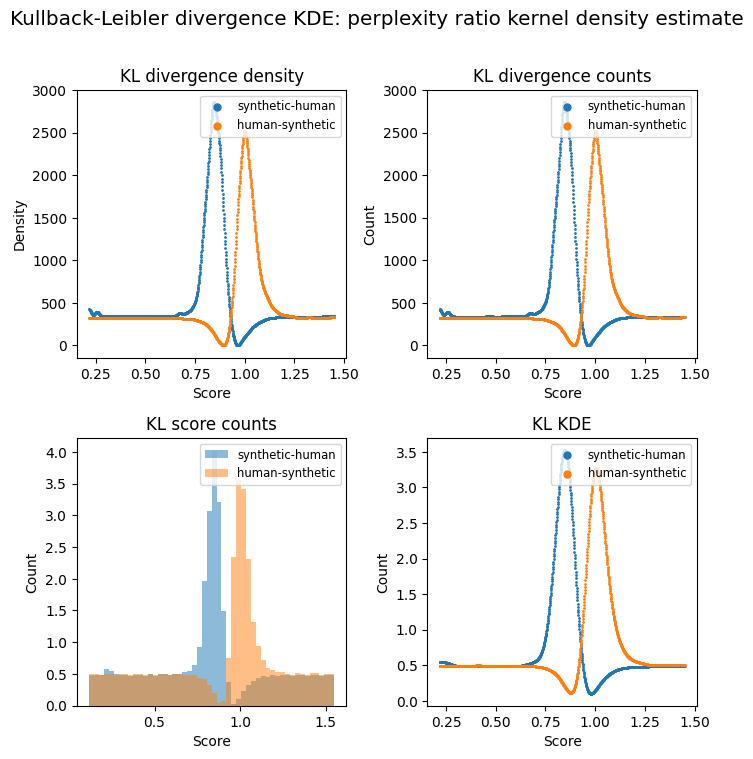

In [11]:
kde_synthetic_human_kld_kde, kde_human_synthetic_kld_kde, plt = helper_funcs.get_kl_kde(
    'Kullback-Leibler divergence KDE: perplexity ratio kernel density estimate', 
    scores, 
    human_kde, 
    synthetic_kde,
    0.1,
    0.001
)

plt.show()

OK, cool. Looks good. Now we can run the perplexity ratio score column from the complete dataset through the Kullback-Leibler divergence distribution's kernel density estimate probability density function to get 'Kullback-Leibler scores' and add them to the dataframe.

In [12]:
# Get the KLD scores
synthetic_human_kld_scores = exp_gaussian_synthetic_human_kld_kde.pdf(data.all.combined['Perplexity ratio score'])
human_synthetic_kld_scores = exp_gaussian_human_synthetic_kld_kde.pdf(data.all.combined['Perplexity ratio score'])

# Add the scores to the dataframe
data.all.combined['Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score'] = synthetic_human_kld_scores
data.all.combined['Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score'] = human_synthetic_kld_scores

# Get the KLD scores
synthetic_human_kld_scores = kde_synthetic_human_kld_kde.pdf(data.all.combined['Perplexity ratio score'])
human_synthetic_kld_scores = kde_human_synthetic_kld_kde.pdf(data.all.combined['Perplexity ratio score'])

# Add the scores to the dataframe
data.all.combined['Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score'] = synthetic_human_kld_scores
data.all.combined['Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score'] = human_synthetic_kld_scores

In [13]:
# Update the rest of the data in the class instance so the new columns propagate
data.update_data(data.all.combined)

# Take a look one of the other datasets in the feature engineering class instance
# to be sure that the new columns propagated correctly
data.training.all.combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21443 entries, 0 to 21442
Data columns (total 18 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Source record num                                                                 21443 non-null  int64  
 1   Fragment length (words)                                                           21443 non-null  int64  
 2   Fragment length (tokens)                                                          21443 non-null  int64  
 3   Dataset                                                                           21443 non-null  object 
 4   Source                                                                            21443 non-null  object 
 5   Generator                                                                         21443 non-null  object 
 6 

Re-plot just to be sure we got the result we expected

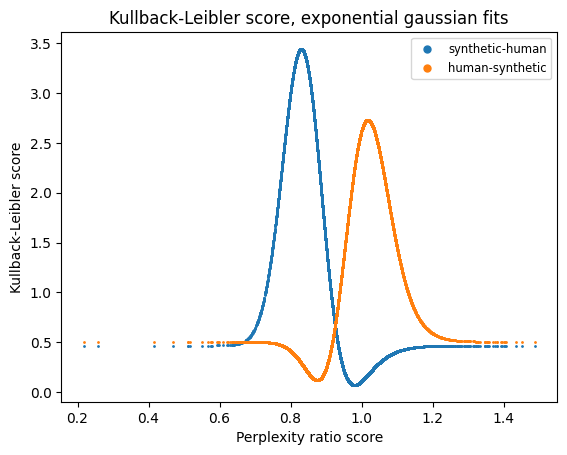

In [14]:
plt.title('Kullback-Leibler score, exponential gaussian fits')
plt.scatter(data.all.combined['Perplexity ratio score'], data.all.combined['Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score'], s = 1, label = 'synthetic-human')
plt.scatter(data.all.combined['Perplexity ratio score'], data.all.combined['Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score'], s = 1, label = 'human-synthetic')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Kullback-Leibler score')
plt.legend(loc = 'upper right', fontsize = 'small', markerscale = 5)
plt.show()

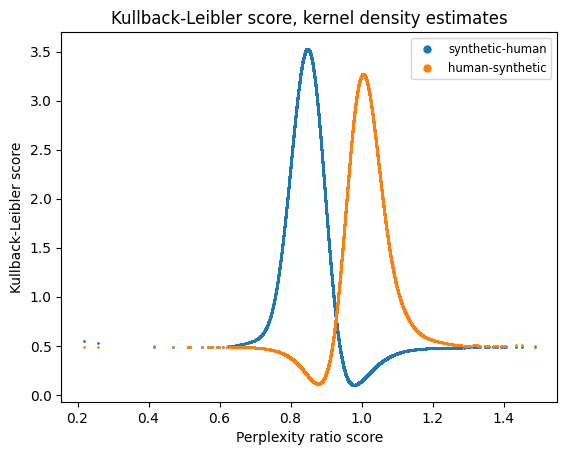

In [15]:
plt.title('Kullback-Leibler score, kernel density estimates')
plt.scatter(data.all.combined['Perplexity ratio score'], data.all.combined['Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score'], s = 1, label = 'synthetic-human')
plt.scatter(data.all.combined['Perplexity ratio score'], data.all.combined['Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score'], s = 1, label = 'human-synthetic')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Kullback-Leibler score')
plt.legend(loc = 'upper right', fontsize = 'small', markerscale = 5)
plt.show()

Nailed it! Save for the next step.

In [16]:
# Persist the feature engineering class instance so we can
# use it in other notebooks
with open(config.FEATURE_ENGINEERING_CLASS_INSTANCE, 'wb') as file:
    pickle.dump(data, file)